---
title: Fashion MNIST
categories: deep-learning
date: 2020-12-15
---


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)

## 初始化

首先引入所用的包。然后是一些公共函数。下面代码比较长，可以先把函数的中文解释看过就好，细节忽略，后面用到再回来看。

In [30]:
import sys
import numpy as np
from tensorflow.keras import Model, layers, regularizers, preprocessing

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from image_classification import set_gpu_memory, lr_schedule, image_data_generator 
from image_classification import ImageClassificationHelper, ImageDataset, DictToObject

set_gpu_memory(1024)
model_results={}

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

# #当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload

set max gpu memory to 1024
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


下面初始化模型运行的参数。

In [31]:
def image_data_generator():
    datagen = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 
    return datagen 

params = {
    'dataset_name': 'cifar10',
    'validation_percent': 0,    
    'use_data_augmentation': True,
    'augmentation_generator': image_data_generator(),     
    'batch_size': 32,    
    'epochs': 120,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1},
        'lenet':{'dropout':0.1},
        'custom':{'dropout':0.1},
        'vgg':{'dropout':0.3},
        'resnet':{}
    }
}

params = DictToObject(params)
helper = ImageClassificationHelper(params=params, 
                                   data=ImageDataset(params), 
                                   model_results=model_results)

load cifar10 data from source
train: (50000, 32, 32, 3) (50000,)
test: (10000, 32, 32, 3) (10000,)
create train, validation and test dataset


## 数据

数据集包含50,000张training图片和10,000张test图片，每张图片由$32\times32$ 个像素点构成。下面查看一下其中的图片。

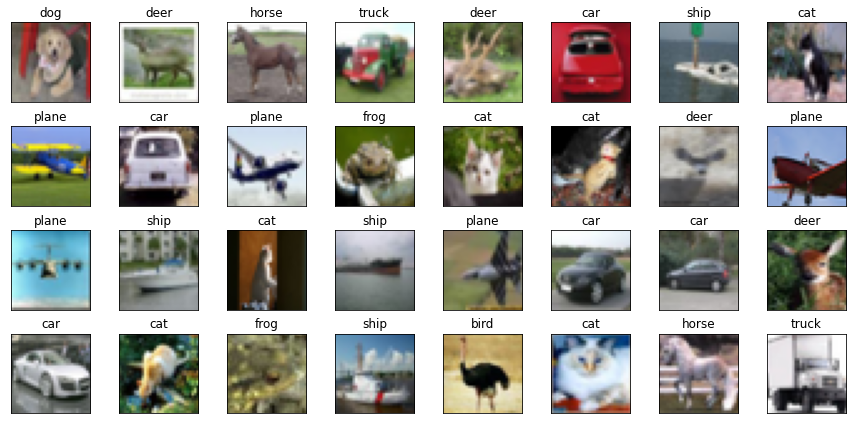

In [3]:
images, labels = iter(helper.data.train_dataset).next()
helper.show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6))

然后看看做了data augmentation的图片。

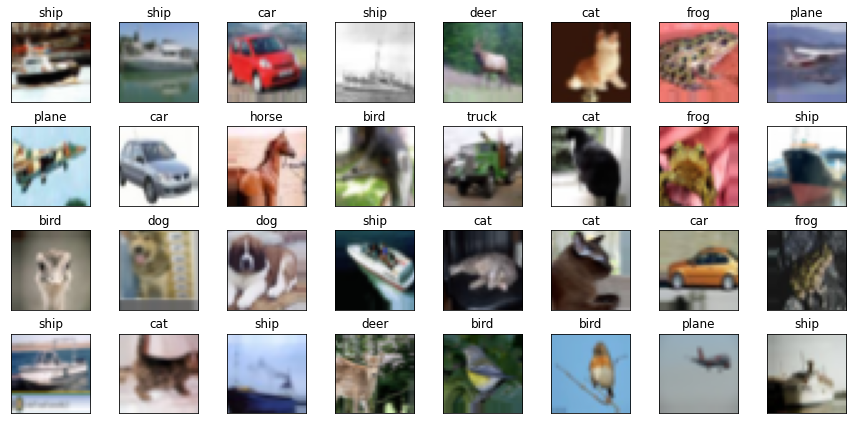

In [4]:
images, labels = helper.data.train_dataset_aug.next()
helper.show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6))

下面来看看各个class的数据分布。可以看到各个数字的分布还是比较均匀的。

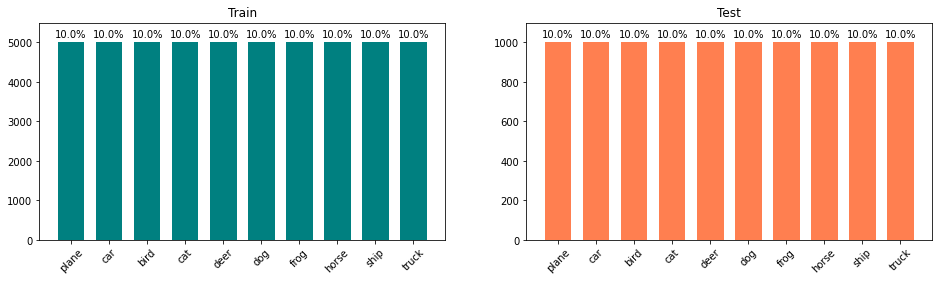

In [5]:
helper.plot_distribution()

## MLP

In [6]:
def get_mlp(helper, name='mlp', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name) 
    print('dropout={}'.format(dropout))
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Flatten()(input)
    x = layers.Dense(128, activation='relu')(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model

model = get_mlp(helper)
model.summary()

dropout=0.1
learning_rate=0.001
checkpoint_path=./checkpoints/cifar10/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________




下面来训练模型。

2020-12-31 09:10:42,425: INFO: start training


use ModelCheckpoint(filepath=./checkpoints/cifar10/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
using data augmentation
Epoch 1/120
1562/1562 [==============================] - 30s 19ms/step - loss: 2.0092 - accuracy: 0.2543 - val_loss: 1.8376 - val_accuracy: 0.3285
Epoch 2/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.9066 - accuracy: 0.2966 - val_loss: 1.7967 - val_accuracy: 0.3443
Epoch 3/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.8775 - accuracy: 0.3069 - val_loss: 1.8188 - val_accuracy: 0.3324
Epoch 4/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.8662 - accuracy: 0.3135 - val_loss: 1.7963 - val_accuracy: 0.3557
Epoch 5/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.8598 - accuracy: 0.3145 - val_loss: 1.7438 - val_accurac

Epoch 108/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7296 - accuracy: 0.3697 - val_loss: 1.6137 - val_accuracy: 0.4203
Epoch 109/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7323 - accuracy: 0.3682 - val_loss: 1.6136 - val_accuracy: 0.4208
Epoch 110/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7303 - accuracy: 0.3690 - val_loss: 1.6137 - val_accuracy: 0.4196
Epoch 111/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7371 - accuracy: 0.3669 - val_loss: 1.6137 - val_accuracy: 0.4205
Epoch 112/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7345 - accuracy: 0.3708 - val_loss: 1.6136 - val_accuracy: 0.4203
Epoch 113/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7354 - accuracy: 0.3673 - val_loss: 1.6137 - val_accuracy: 0.4200
Epoch 114/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7341 - accuracy: 0.3698

2020-12-31 10:10:31,883: INFO: finish training [elapsed time: 3589.46 seconds]


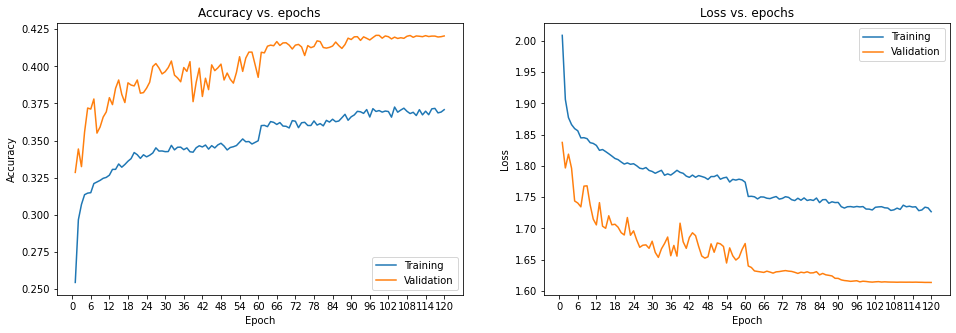

In [7]:
history = helper.train(model, epochs=helper.params.epochs)

---------------------------------------- evaluate ----------------------------------------
Test loss:1.6152, Test Accuracy:42.09%
---------------------------------------- confusion matrix ----------------------------------------


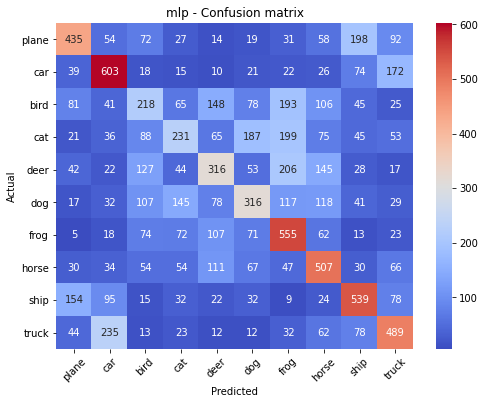

---------------------------------------- model improvement ----------------------------------------


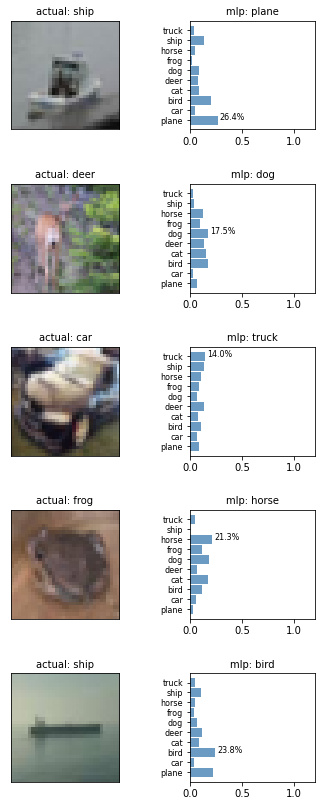

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,1.613587,0.425,1.615194,0.4209,394634,3589.0


In [15]:
helper.model_summary(model, history=history)




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

## LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [16]:
def get_lenet(helper, name='lenet', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name) 
    print('dropout={}'.format(dropout))
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Conv2D(6, (5, 5), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)   
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(84, activation='relu')(x)   
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)  

    return model    

# 创建模型
model = get_lenet(helper)
model.summary()

dropout=0.1
learning_rate=0.001
checkpoint_path=./checkpoints/cifar10/lenet/checkpoint
Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
________________________________________



下面来训练模型。

2020-12-31 12:13:58,059: INFO: start training


use ModelCheckpoint(filepath=./checkpoints/cifar10/lenet/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
use data augmentation
Epoch 1/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.7137 - accuracy: 0.3762 - val_loss: 1.4213 - val_accuracy: 0.4933
Epoch 2/120
1562/1562 [==============================] - 29s 18ms/step - loss: 1.4702 - accuracy: 0.4700 - val_loss: 1.3166 - val_accuracy: 0.5283
Epoch 3/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.3835 - accuracy: 0.5034 - val_loss: 1.3094 - val_accuracy: 0.5269
Epoch 4/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.3228 - accuracy: 0.5271 - val_loss: 1.2519 - val_accuracy: 0.5558
Epoch 5/120
1562/1562 [==============================] - 29s 18ms/step - loss: 1.2700 - accuracy: 0.5475 - val_loss: 1.1405 - val_accurac

1562/1562 [==============================] - 28s 18ms/step - loss: 0.8469 - accuracy: 0.7032 - val_loss: 0.7673 - val_accuracy: 0.7315
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8411 - accuracy: 0.7027 - val_loss: 0.7644 - val_accuracy: 0.7313
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epoch 106/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8570 - accuracy: 0.6986 - val_loss: 0.7682 - val_accuracy: 0.7312
Epoch 107/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8481 - accuracy: 0.7011 - val_loss: 0.7651 - val_accuracy: 0.7326
Epoch 108/120
1562/1562 [==============================] - 29s 18ms/step - loss: 0.8501 - accuracy: 0.7025 - val_loss: 0.7681 - val_accuracy: 0.7317
Epoch 109/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8489 - accuracy: 0.7025 - val_loss: 0.7671

2020-12-31 13:11:06,114: INFO: finish training [elapsed time: 3428.06 seconds]


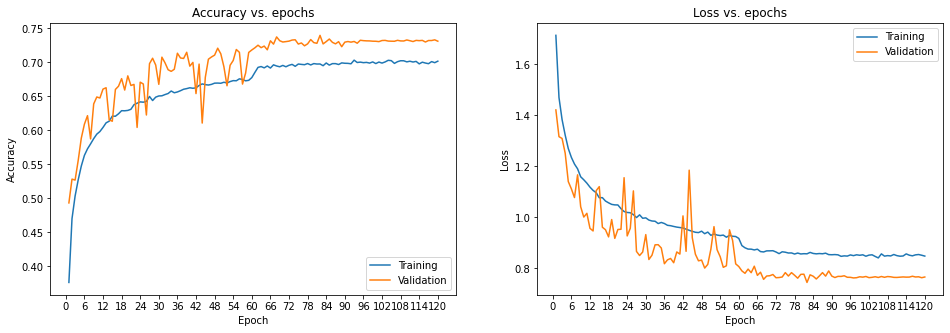

In [17]:
# 训练
history = helper.train(model, epochs=helper.params.epochs)



下面来评估模型并和mlp模型进行对比。

---------------------------------------- evaluate ----------------------------------------
Test loss:0.7449, Test Accuracy:73.99%
---------------------------------------- confusion matrix ----------------------------------------


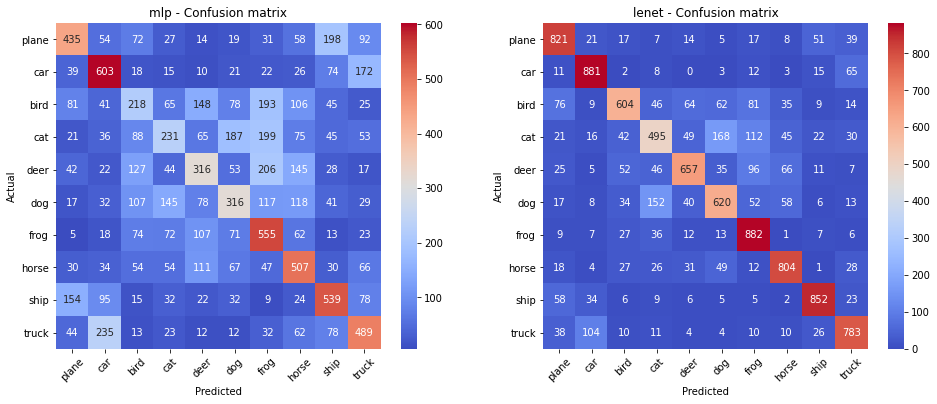

---------------------------------------- model improvement ----------------------------------------


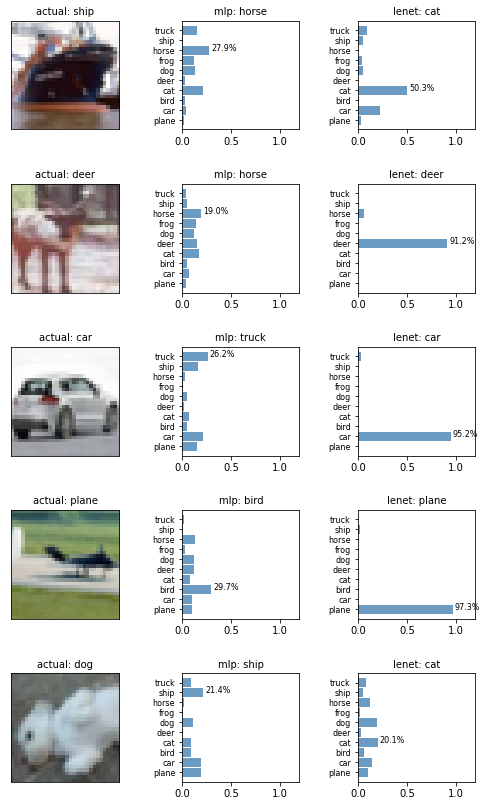

---------------------------------------- error analysis ----------------------------------------


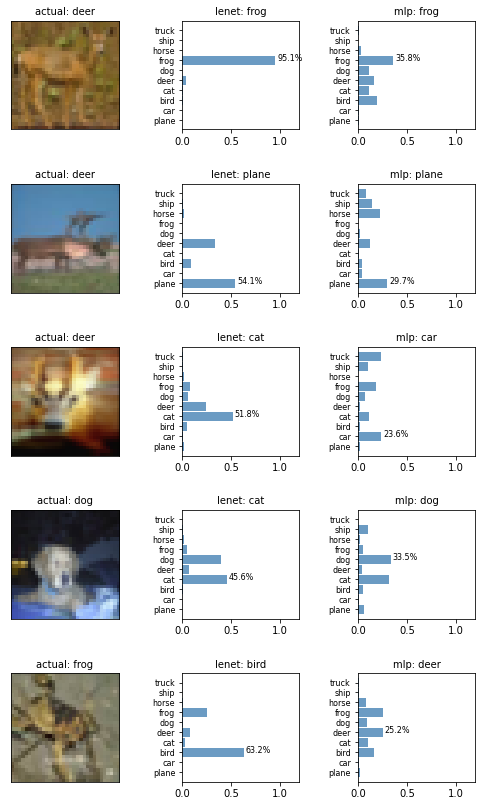

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
lenet,0.625302,0.7795,0.744942,0.7399,83170,3428.0
mlp,1.613587,0.4250,1.615194,0.4209,394634,3589.0


In [18]:
helper.model_summary(model, history=history)



从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。


上图中，可以看到对于部分数字的识别，mlp甚至要更好一点啊，还有一些数字，则是一起都错了。

## Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度。

In [19]:
def get_custom1(helper, name='custom_cnn', dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name)
    print('dropout={}'.format(dropout))
        
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) 
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model   

# 创建模型
model = get_custom1(helper)
model.summary()

dropout=0.1
learning_rate=0.001
checkpoint_path=./checkpoints/cifar10/custom_cnn/checkpoint
Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
______________________________


可以发现参数的个数已经和mlp差不多了，下面来训练模型。

2020-12-31 13:11:21,331: INFO: start training


use ModelCheckpoint(filepath=./checkpoints/cifar10/custom_cnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
use data augmentation
Epoch 1/120
1562/1562 [==============================] - 29s 18ms/step - loss: 1.6048 - accuracy: 0.4231 - val_loss: 1.3019 - val_accuracy: 0.5235
Epoch 2/120
1562/1562 [==============================] - 29s 18ms/step - loss: 1.2952 - accuracy: 0.5366 - val_loss: 1.1248 - val_accuracy: 0.5954
Epoch 3/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.1697 - accuracy: 0.5843 - val_loss: 1.2019 - val_accuracy: 0.5792
Epoch 4/120
1562/1562 [==============================] - 29s 18ms/step - loss: 1.0974 - accuracy: 0.6122 - val_loss: 1.0731 - val_accuracy: 0.6264
Epoch 5/120
1562/1562 [==============================] - 28s 18ms/step - loss: 1.0374 - accuracy: 0.6340 - val_loss: 0.9441 - val_ac

1562/1562 [==============================] - 28s 18ms/step - loss: 0.5796 - accuracy: 0.7996 - val_loss: 0.5213 - val_accuracy: 0.8218
Epoch 00101: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 101/120
1562/1562 [==============================] - 29s 18ms/step - loss: 0.5832 - accuracy: 0.7971 - val_loss: 0.5211 - val_accuracy: 0.8215
Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.5810 - accuracy: 0.7957 - val_loss: 0.5215 - val_accuracy: 0.8222
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
1562/1562 [==============================] - 28s 18ms/step - loss: 0.5801 - accuracy: 0.8002 - val_loss: 0.5206 - val_accuracy: 0.8224
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
1562/1562 [==============================] - 29s 18ms/step - loss: 0.5806 - accuracy: 0.7996 - val_loss: 0.5212 - val_accuracy: 0.8218
Epoch 00105: Stil

2020-12-31 14:08:26,724: INFO: finish training [elapsed time: 3425.39 seconds]


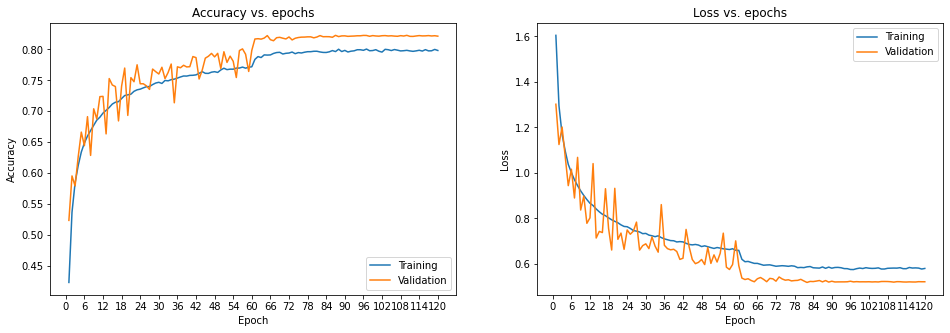

In [20]:
# 训练
history = helper.train(model, epochs=helper.params.epochs)



下面来评估模型并和lenet模型进行对比。

In [1]:
helper.model_summary(model, history=history)

NameError: name 'helper' is not defined



可以看到custom1模型的效果比lenet有些许提升（经过多次测试，平均好0.1-0.3个百分点）。上面最后一幅图，也能看到custom1模型学习到了不少新的模式。下面来看错误分析。

## VGG

In [22]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, dropout=0, block_name='block'):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, name='{}_con{}'.format(block_name, i+1))(x)
        if use_bn: x = layers.BatchNormalization(name='{}_bn{}'.format(block_name, i+1))(x)
        x = layers.ReLU(name='{}_relu{}'.format(block_name, i+1))(x)
    x = layers.MaxPooling2D((2, 2), name='{}_maxpooling1'.format(block_name))(x)
    if dropout>0: x = layers.Dropout(dropout, name='{}_dropout1'.format(block_name))(x)
    return x
    
def get_vgg(helper, name='vgg',
              dense_layer_count=1, 
              dense_layer_units=128,
              conv_filters=64,
              block_count=3,
              use_bn=True,
              dropout=None):
    if dropout is None:
        dropout = helper.get_dropout(name)
    print('dropout={}'.format(dropout))
        
    input = layers.Input(shape=helper.data.input_shape)
    x = input    
    for i in range(block_count): 
        x = get_block(x, conv_filters, conv_count=2, use_bn=use_bn, dropout=dropout, 
                      block_name='block{}'.format(i+1))
        conv_filters = conv_filters*2
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)
    return model


model = get_vgg(helper, dense_layer_count=1, block_count=3, name='vgg8')
model.summary()



dropout=0.3
learning_rate=0.001
checkpoint_path=./checkpoints/cifar10/vgg8/checkpoint
Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 32, 32, 64)        256       
__________________________________________

In [23]:
# 训练
history = helper.train(model, epochs=helper.params.epochs)

2020-12-31 14:08:43,559: INFO: start training


use ModelCheckpoint(filepath=./checkpoints/cifar10/vgg8/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
use data augmentation
Epoch 1/120
1562/1562 [==============================] - 30s 19ms/step - loss: 2.1288 - accuracy: 0.1904 - val_loss: 2.0016 - val_accuracy: 0.2353
Epoch 2/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.8794 - accuracy: 0.2667 - val_loss: 1.5208 - val_accuracy: 0.4122
Epoch 3/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.7093 - accuracy: 0.3218 - val_loss: 1.4066 - val_accuracy: 0.4648
Epoch 4/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.6352 - accuracy: 0.3657 - val_loss: 1.4075 - val_accuracy: 0.4915
Epoch 5/120
1562/1562 [==============================] - 29s 19ms/step - loss: 1.5352 - accuracy: 0.4100 - val_loss: 1.1583 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.2967 - accuracy: 0.8995 - val_loss: 0.3674 - val_accuracy: 0.8838
Epoch 43/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2883 - accuracy: 0.9025 - val_loss: 0.3609 - val_accuracy: 0.8926
Epoch 44/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2833 - accuracy: 0.9053 - val_loss: 0.4639 - val_accuracy: 0.8701
Epoch 45/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2793 - accuracy: 0.9065 - val_loss: 0.3970 - val_accuracy: 0.8815
Epoch 46/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2802 - accuracy: 0.9059 - val_loss: 0.4237 - val_accuracy: 0.8795
Epoch 47/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2765 - accuracy: 0.9071 - val_loss: 0.3507 - val_accuracy: 0.8908
Epoch 48/120
 631/1562 [===========>..................] - ETA: 16s - loss: 0.2770 - accuracy: 0.9064

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.2561 - accuracy: 0.9140 - val_loss: 0.3547 - val_accuracy: 0.8975
Epoch 55/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2489 - accuracy: 0.9166 - val_loss: 0.3710 - val_accuracy: 0.8886
Epoch 56/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2430 - accuracy: 0.9175 - val_loss: 0.3487 - val_accuracy: 0.9001
Epoch 57/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2459 - accuracy: 0.9162 - val_loss: 0.3459 - val_accuracy: 0.8970
Epoch 58/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2395 - accuracy: 0.9198 - val_loss: 0.3837 - val_accuracy: 0.8930
Epoch 59/120
1228/1562 [======================>.......] - ETA: 5s - loss: 0.2310 - accuracy: 0.9206

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1716 - accuracy: 0.9411 - val_loss: 0.3247 - val_accuracy: 0.9121
Epoch 66/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1697 - accuracy: 0.9414 - val_loss: 0.3139 - val_accuracy: 0.9139
Epoch 67/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1686 - accuracy: 0.9428 - val_loss: 0.3165 - val_accuracy: 0.9147
Epoch 68/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1629 - accuracy: 0.9438 - val_loss: 0.3163 - val_accuracy: 0.9129
Epoch 69/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1636 - accuracy: 0.9444 - val_loss: 0.3127 - val_accuracy: 0.9155
Epoch 70/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1584 - accuracy: 0.9464 - val_loss: 0.3210 - val_accuracy: 0.9149
Epoch 71/120
 142/1562 [=>............................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9452

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1538 - accuracy: 0.9470 - val_loss: 0.3165 - val_accuracy: 0.9162
Epoch 77/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1514 - accuracy: 0.9474 - val_loss: 0.3281 - val_accuracy: 0.9159
Epoch 78/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1480 - accuracy: 0.9484 - val_loss: 0.3135 - val_accuracy: 0.9182
Epoch 79/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1500 - accuracy: 0.9480 - val_loss: 0.3181 - val_accuracy: 0.9137
Epoch 80/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1514 - accuracy: 0.9478 - val_loss: 0.3170 - val_accuracy: 0.9164
Epoch 81/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1495 - accuracy: 0.9482 - val_loss: 0.3190 - val_accuracy: 0.9153
Epoch 82/120
 595/1562 [==========>...................] - ETA: 17s - loss: 0.1428 - accuracy: 0.9484

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1419 - accuracy: 0.9508 - val_loss: 0.3214 - val_accuracy: 0.9170
Epoch 00089: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 89/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1398 - accuracy: 0.9524 - val_loss: 0.3201 - val_accuracy: 0.9166
Epoch 00090: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 90/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1407 - accuracy: 0.9516 - val_loss: 0.3176 - val_accuracy: 0.9164
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 3.16e-05.
Epoch 91/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1410 - accuracy: 0.9527 - val_loss: 0.3168 - val_accuracy: 0.9167
Epoch 92/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1365 - accuracy: 0.9524 - val_loss: 0.3159 - val_accuracy: 0.9176
Epoch 93/120
  76/1562 [>.............................] - ETA

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1375 - accuracy: 0.9512 - val_loss: 0.3154 - val_accuracy: 0.9175
Epoch 95/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1383 - accuracy: 0.9528 - val_loss: 0.3153 - val_accuracy: 0.9176
Epoch 96/120
  37/1562 [..............................] - ETA: 26s - loss: 0.1342 - accuracy: 0.9502

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1384 - accuracy: 0.9531 - val_loss: 0.3173 - val_accuracy: 0.9167
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1351 - accuracy: 0.9529 - val_loss: 0.3189 - val_accuracy: 0.9167
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1336 - accuracy: 0.9542 - val_loss: 0.3163 - val_accuracy: 0.9165
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.1372 - accuracy: 0.9523 - val_loss: 0.3184 - val_accuracy: 0.9168
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epoch 106/120
1111/1562 [====================>.........] - ETA: 8s - loss: 0.1345 - accuracy: 0.9543

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.1354 - accuracy: 0.9534 - val_loss: 0.3168 - val_accuracy: 0.9171
Epoch 109/120
1124/1562 [====================>.........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9530

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



---------------------------------------- evaluate ----------------------------------------
Test loss:0.3126, Test Accuracy:91.86%
---------------------------------------- confusion matrix ----------------------------------------


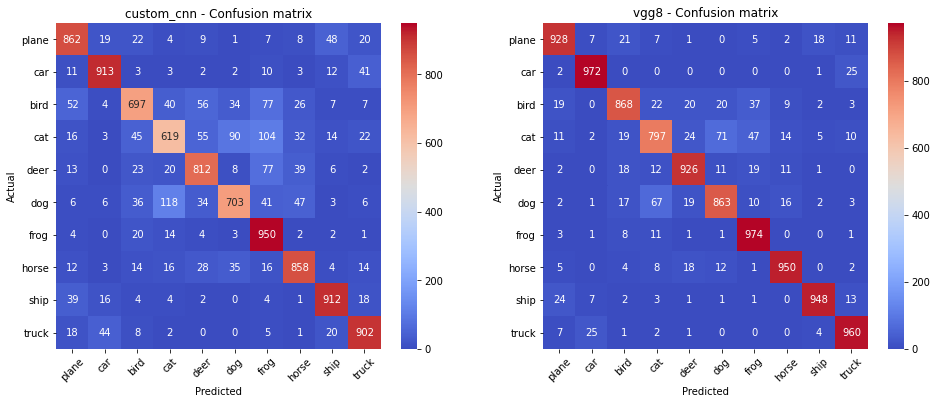

---------------------------------------- model improvement ----------------------------------------


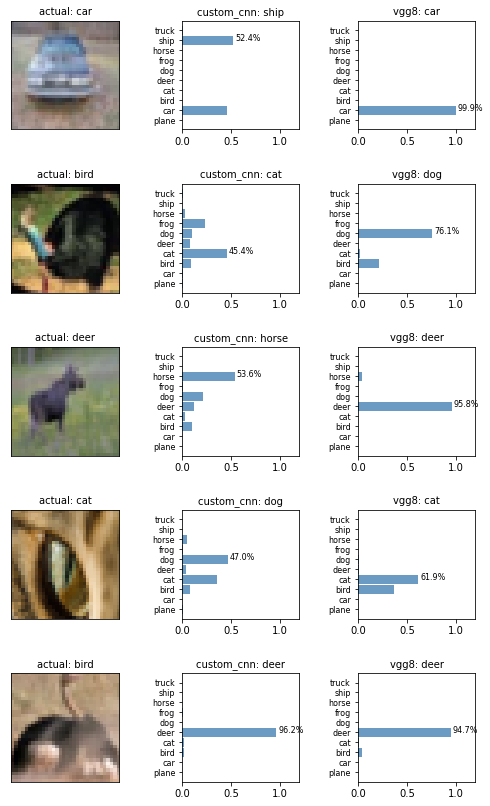

---------------------------------------- error analysis ----------------------------------------


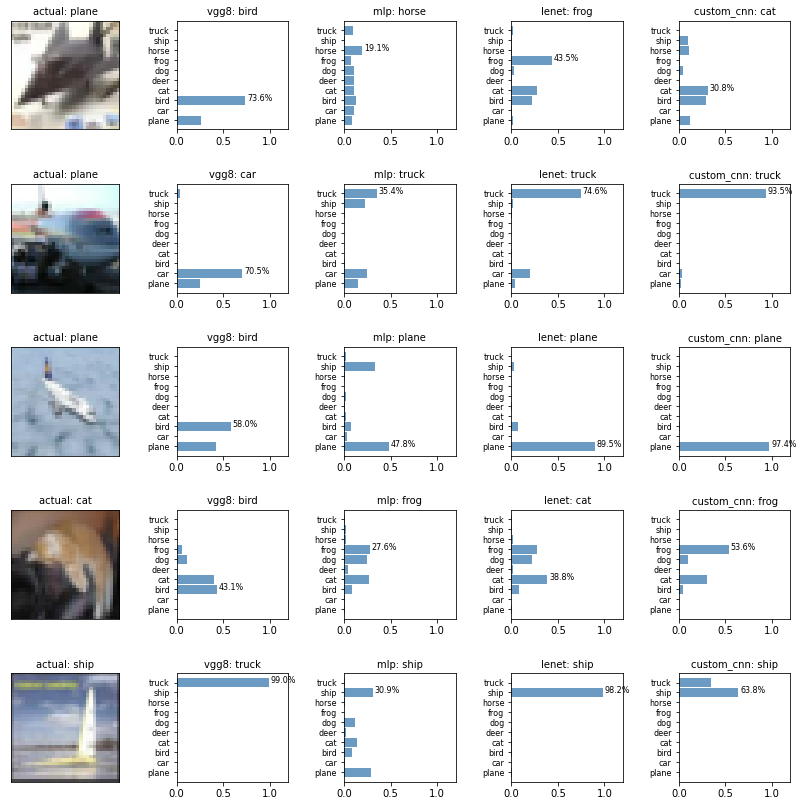

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
vgg8,0.058414,0.9792,0.312647,0.9186,1672906,3294.0
custom_cnn,0.423203,0.8529,0.520976,0.8228,73738,3425.0
lenet,0.625302,0.7795,0.744942,0.7399,83170,3428.0
mlp,1.613587,0.4250,1.615194,0.4209,394634,3589.0


In [24]:
helper.model_summary(model, history=history)

## Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [25]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10, name='resnet_v1'):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)

        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=7)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model

def get_resnet_v1(helper, depth=32, name='resnet_v1'):       
    model = resnet_v1(helper.data.input_shape, depth=depth, name='{}_{}'.format(name, depth))
    helper.compile(model)
    return model

model = get_resnet_v1(helper, depth=20)
model.summary()

learning_rate=0.001
checkpoint_path=./checkpoints/cifar10/resnet_v1_20/checkpoint
Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization_5[0][0]      
_____

2020-12-31 15:03:57,680: INFO: start training


use ModelCheckpoint(filepath=./checkpoints/cifar10/resnet_v1_20/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
use data augmentation
Epoch 1/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.5597 - accuracy: 0.4913 - val_loss: 1.4803 - val_accuracy: 0.5309
Epoch 2/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.1496 - accuracy: 0.6497 - val_loss: 1.6335 - val_accuracy: 0.5549
Epoch 3/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.9999 - accuracy: 0.7067 - val_loss: 1.3044 - val_accuracy: 0.6260
Epoch 4/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.9110 - accuracy: 0.7419 - val_loss: 1.1037 - val_accuracy: 0.6826
Epoch 5/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.8522 - accuracy: 0.7632 - val_loss: 1.1104 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.6627 - accuracy: 0.8349 - val_loss: 0.8908 - val_accuracy: 0.7716
Epoch 14/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.6471 - accuracy: 0.8410 - val_loss: 0.8269 - val_accuracy: 0.7916
Epoch 15/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6415 - accuracy: 0.8448 - val_loss: 0.6872 - val_accuracy: 0.8322
Epoch 16/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.6290 - accuracy: 0.8488 - val_loss: 0.9435 - val_accuracy: 0.7675
Epoch 17/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6281 - accuracy: 0.8490 - val_loss: 0.9401 - val_accuracy: 0.7719
Epoch 18/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6172 - accuracy: 0.8543 - val_loss: 0.8205 - val_accuracy: 0.8031
Epoch 19/120
 864/1562 [===============>..............] - ETA: 12s - loss: 0.6093 - accuracy: 0.8577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 30s 19ms/step - loss: 0.5730 - accuracy: 0.8726 - val_loss: 0.7290 - val_accuracy: 0.8283
Epoch 28/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.5662 - accuracy: 0.8753 - val_loss: 0.7565 - val_accuracy: 0.8252
Epoch 29/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5636 - accuracy: 0.8751 - val_loss: 0.7047 - val_accuracy: 0.8405
Epoch 30/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5592 - accuracy: 0.8789 - val_loss: 0.8099 - val_accuracy: 0.8069
Epoch 31/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5555 - accuracy: 0.8791 - val_loss: 0.6441 - val_accuracy: 0.8538
Epoch 32/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5522 - accuracy: 0.8813 - val_loss: 0.7223 - val_accuracy: 0.8299
Epoch 33/120
 287/1562 [====>.........................] - ETA: 22s - loss: 0.5381 - accuracy: 0.8838

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 30s 19ms/step - loss: 0.5332 - accuracy: 0.8884 - val_loss: 0.8099 - val_accuracy: 0.8079
Epoch 42/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.5277 - accuracy: 0.8912 - val_loss: 0.6904 - val_accuracy: 0.8438
Epoch 43/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5325 - accuracy: 0.8881 - val_loss: 0.7575 - val_accuracy: 0.8238
Epoch 44/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5271 - accuracy: 0.8899 - val_loss: 0.7980 - val_accuracy: 0.8197
Epoch 45/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5277 - accuracy: 0.8899 - val_loss: 0.6978 - val_accuracy: 0.8382
Epoch 46/120
1197/1562 [=====================>........] - ETA: 6s - loss: 0.5275 - accuracy: 0.8917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 30s 19ms/step - loss: 0.5134 - accuracy: 0.8954 - val_loss: 0.6511 - val_accuracy: 0.8557
Epoch 55/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5138 - accuracy: 0.8952 - val_loss: 0.8421 - val_accuracy: 0.8102
Epoch 56/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5108 - accuracy: 0.8986 - val_loss: 0.6437 - val_accuracy: 0.8538
Epoch 57/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5123 - accuracy: 0.8954 - val_loss: 0.6823 - val_accuracy: 0.8445
Epoch 58/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.5112 - accuracy: 0.8971 - val_loss: 0.7694 - val_accuracy: 0.8295
Epoch 59/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5128 - accuracy: 0.8969 - val_loss: 0.7193 - val_accuracy: 0.8420
Epoch 60/120
 309/1562 [====>.........................] - ETA: 22s - loss: 0.4858 - accuracy: 0.9010

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 30s 19ms/step - loss: 0.3321 - accuracy: 0.9506 - val_loss: 0.4760 - val_accuracy: 0.9071
Epoch 68/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3248 - accuracy: 0.9520 - val_loss: 0.4780 - val_accuracy: 0.9074
Epoch 69/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3175 - accuracy: 0.9533 - val_loss: 0.4690 - val_accuracy: 0.9074
Epoch 70/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3108 - accuracy: 0.9557 - val_loss: 0.4758 - val_accuracy: 0.9077
Epoch 71/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3069 - accuracy: 0.9553 - val_loss: 0.4752 - val_accuracy: 0.9060
Epoch 72/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2982 - accuracy: 0.9573 - val_loss: 0.4820 - val_accuracy: 0.9069
Epoch 73/120
1083/1562 [===================>..........] - ETA: 8s - loss: 0.2927 - accuracy: 0.9575

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 30s 19ms/step - loss: 0.2593 - accuracy: 0.9651 - val_loss: 0.4644 - val_accuracy: 0.9066
Epoch 82/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2564 - accuracy: 0.9658 - val_loss: 0.4833 - val_accuracy: 0.9030
Epoch 83/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2524 - accuracy: 0.9660 - val_loss: 0.4627 - val_accuracy: 0.9064
Epoch 84/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2504 - accuracy: 0.9664 - val_loss: 0.4579 - val_accuracy: 0.9074
Epoch 85/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2454 - accuracy: 0.9682 - val_loss: 0.4698 - val_accuracy: 0.9051
Epoch 86/120
1300/1562 [=======================>......] - ETA: 4s - loss: 0.2440 - accuracy: 0.9678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.2168 - accuracy: 0.9745 - val_loss: 0.4491 - val_accuracy: 0.9106
Epoch 95/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2143 - accuracy: 0.9756 - val_loss: 0.4511 - val_accuracy: 0.9098
Epoch 96/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2129 - accuracy: 0.9765 - val_loss: 0.4496 - val_accuracy: 0.9102
Epoch 97/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2147 - accuracy: 0.9751 - val_loss: 0.4495 - val_accuracy: 0.9111
Epoch 98/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2115 - accuracy: 0.9767 - val_loss: 0.4503 - val_accuracy: 0.9100
Epoch 99/120
1467/1562 [===========================>..] - ETA: 1s - loss: 0.2119 - accuracy: 0.9763

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.2074 - accuracy: 0.9773 - val_loss: 0.4495 - val_accuracy: 0.9121
Epoch 108/120
1562/1562 [==============================] - 29s 19ms/step - loss: 0.2062 - accuracy: 0.9783 - val_loss: 0.4494 - val_accuracy: 0.9113
Epoch 109/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2067 - accuracy: 0.9772 - val_loss: 0.4472 - val_accuracy: 0.9114
Epoch 110/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2074 - accuracy: 0.9771 - val_loss: 0.4460 - val_accuracy: 0.9119
Epoch 111/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2063 - accuracy: 0.9767 - val_loss: 0.4472 - val_accuracy: 0.9117
Epoch 112/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2063 - accuracy: 0.9780 - val_loss: 0.4468 - val_accuracy: 0.9119
Epoch 113/120
  34/1562 [..............................] - ETA: 26s - loss: 0.2050 - accuracy: 0.9807

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 29s 19ms/step - loss: 0.2063 - accuracy: 0.9776 - val_loss: 0.4474 - val_accuracy: 0.9121


2020-12-31 16:03:20,924: INFO: finish training [elapsed time: 3563.24 seconds]


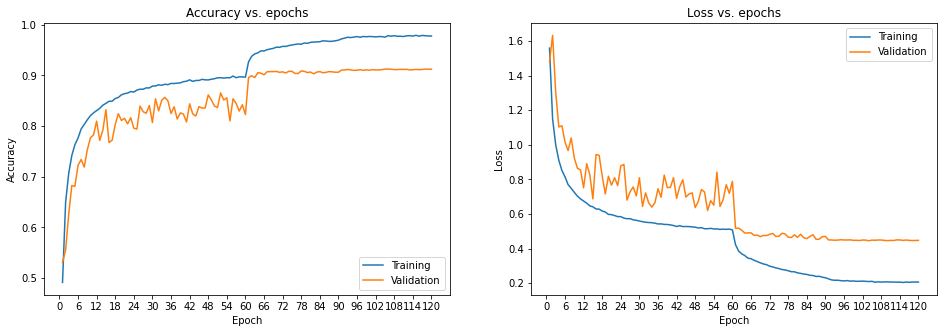

In [26]:
history = helper.train(model, epochs=helper.params.epochs)

---------------------------------------- evaluate ----------------------------------------
Test loss:0.4489, Test Accuracy:91.24%
---------------------------------------- confusion matrix ----------------------------------------


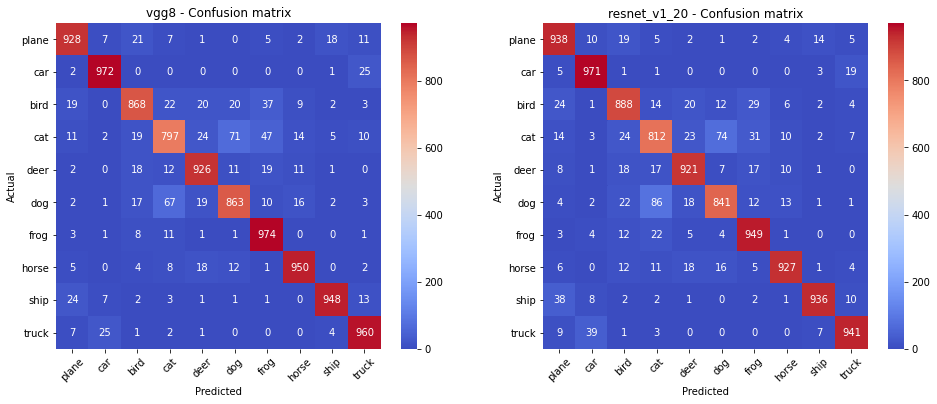

---------------------------------------- model improvement ----------------------------------------


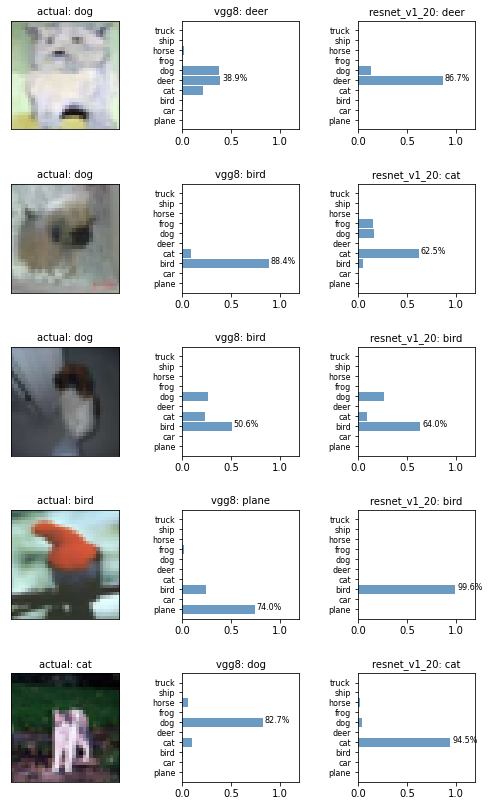

---------------------------------------- error analysis ----------------------------------------


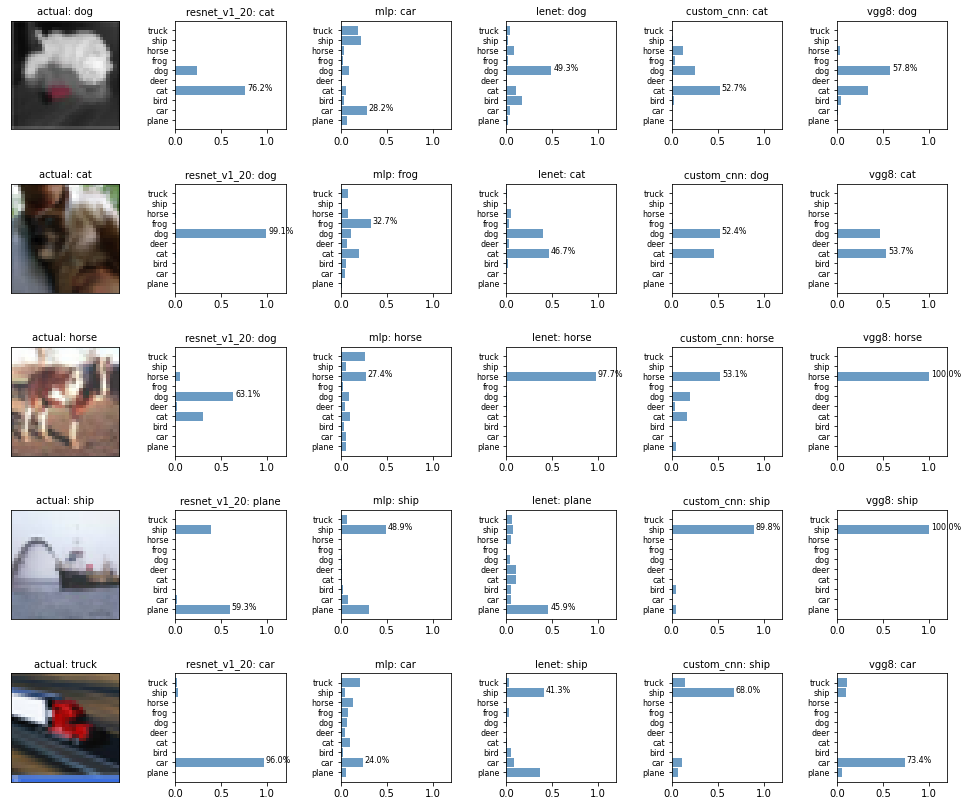

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
vgg8,0.058414,0.9792,0.312647,0.9186,1672906,3294.0
resnet_v1_20,0.201748,0.9786,0.448870,0.9124,273066,3563.0
custom_cnn,0.423203,0.8529,0.520976,0.8228,73738,3425.0
lenet,0.625302,0.7795,0.744942,0.7399,83170,3428.0
mlp,1.613587,0.4250,1.615194,0.4209,394634,3589.0


In [27]:
helper.model_summary(model, history=history)

## 总结